In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [3]:
import malaya_speech
import malaya_speech.config
from malaya_speech.train.model import revsic_glowtts as glowtts
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt

In [4]:
import pickle

with open('dataset-mel.pkl', 'rb') as fopen:
    data, d = pickle.load(fopen)
    
with open('dataset-mel-wav.pkl', 'rb') as fopen:
    wav = pickle.load(fopen)
    
data.keys()

dict_keys(['mel', 'text_ids', 'len_mel', 'len_text_ids', 'stop_token_target', 'f0', 'len_f0', 'energy', 'len_energy', 'g'])

In [5]:
i = tf.placeholder(tf.int32, [None, None])
i_lengths = tf.placeholder(tf.int32, [None])
mel_outputs = tf.placeholder(tf.float32, [None, None, 80])
mel_lengths = tf.placeholder(tf.int32, [None])

In [6]:
config = glowtts.Config(mel = 80, vocabs = 66)

In [7]:
model = glowtts.Model(config)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
loss, losses, attn = model.compute_loss(text = i, textlen = i_lengths, mel = mel_outputs, mellen = mel_lengths)
loss, losses, attn

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


(<tf.Tensor 'add_4:0' shape=() dtype=float32>,
 {'nll': <tf.Tensor 'Mean:0' shape=() dtype=float32>,
  'durloss': <tf.Tensor 'Mean_1:0' shape=() dtype=float32>,
  'mel_': <tf.Tensor 'Reshape_2:0' shape=(?, ?, ?) dtype=float32>},
 <tf.Tensor 'StopGradient:0' shape=(?, ?, ?) dtype=float32>)

In [9]:
mel, mellen, attn_out = model(inputs = i, lengths = i_lengths)
mel, mellen, attn_out

(<tf.Tensor 'model/Reshape_50:0' shape=(?, ?, ?) dtype=float32>,
 <tf.Tensor 'model/mul_90:0' shape=(?,) dtype=int32>,
 <tf.Tensor 'model/transpose:0' shape=(?, ?, ?) dtype=float32>)

In [10]:
parameters = {
    'optimizer_params': {'beta1': 0.9, 'beta2': 0.98, 'epsilon': 1e-9},
    'lr_policy_params': {
        'warmup_steps': 40000,
    },
}

def noam_schedule(step, learning_rate, channels, warmup_steps=4000):
    return learning_rate * channels ** -0.5 * \
            tf.minimum(step ** -0.5, step * warmup_steps ** -1.5)

def learning_rate_scheduler(global_step):
    return transformer_schedule(
        tf.cast(global_step, tf.float32),
        config.channels,
        **parameters['lr_policy_params'],
    )

In [12]:
optimizer = tf.train.AdamOptimizer(learning_rate = 1e-4, beta1 = 0.9, 
                                   beta2 = 0.98, epsilon = 1e-9).minimize(loss)

In [11]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [14]:
%%time

o = sess.run(mel, feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
                                               i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
                                               mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
                                               mel_lengths: [408, 408]})

CPU times: user 555 ms, sys: 144 ms, total: 699 ms
Wall time: 149 ms


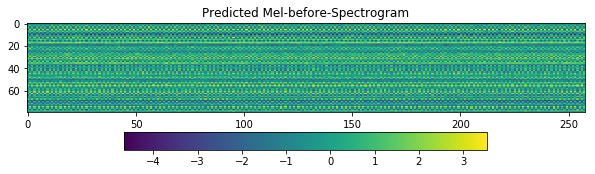

In [16]:
mel_outputs_ = np.reshape(o[0], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [14]:
%%time

o = sess.run([loss, losses, attn], feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
                                               i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
                                               mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
                                               mel_lengths: [408, 408]})

CPU times: user 3.61 s, sys: 231 ms, total: 3.84 s
Wall time: 3.08 s


In [15]:
for k in range(200):
    o = sess.run([loss, losses, optimizer], feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
                                               i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
                                               mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
                                               mel_lengths: [408, 408]})
    print(k, o)

0 [1.5699323, {'nll': 1.211306, 'durloss': 0.3586264}, None]
1 [1.0083202, {'nll': 0.83189213, 'durloss': 0.17642806}, None]
2 [0.7693584, {'nll': 0.61710554, 'durloss': 0.15225288}, None]
3 [0.6011621, {'nll': 0.4528559, 'durloss': 0.14830618}, None]
4 [0.45718062, {'nll': 0.3213082, 'durloss': 0.13587244}, None]
5 [0.44244003, {'nll': 0.19927748, 'durloss': 0.24316257}, None]
6 [0.3217426, {'nll': 0.07830867, 'durloss': 0.24343394}, None]
7 [0.20398791, {'nll': -0.028031383, 'durloss': 0.23201929}, None]
8 [0.14600836, {'nll': -0.100734934, 'durloss': 0.24674329}, None]
9 [0.065987825, {'nll': -0.18512481, 'durloss': 0.25111264}, None]
10 [-0.01136142, {'nll': -0.2676414, 'durloss': 0.25627998}, None]
11 [-0.12761481, {'nll': -0.33790287, 'durloss': 0.21028806}, None]
12 [-0.1754086, {'nll': -0.39530578, 'durloss': 0.21989718}, None]
13 [-0.1880947, {'nll': -0.44292247, 'durloss': 0.25482777}, None]
14 [-0.18436912, {'nll': -0.4722441, 'durloss': 0.287875}, None]
15 [-0.27009338, {'n

125 [-1.7336853, {'nll': -2.034759, 'durloss': 0.30107385}, None]
126 [-1.8754997, {'nll': -2.0740469, 'durloss': 0.19854714}, None]
127 [-1.9294102, {'nll': -2.106569, 'durloss': 0.17715879}, None]
128 [-1.9731785, {'nll': -2.1414785, 'durloss': 0.16830006}, None]
129 [-1.9833845, {'nll': -2.1769485, 'durloss': 0.19356406}, None]
130 [-2.0406883, {'nll': -2.216874, 'durloss': 0.17618552}, None]
131 [-2.0645788, {'nll': -2.2380128, 'durloss': 0.17343391}, None]
132 [-2.0677028, {'nll': -2.2737312, 'durloss': 0.2060285}, None]
133 [-2.1059246, {'nll': -2.2790854, 'durloss': 0.17316087}, None]
134 [-1.8018725, {'nll': -2.0245893, 'durloss': 0.22271675}, None]
135 [-1.7318438, {'nll': -1.908966, 'durloss': 0.17712212}, None]
136 [-1.7119683, {'nll': -1.8888704, 'durloss': 0.17690201}, None]
137 [-1.7705725, {'nll': -1.9880248, 'durloss': 0.21745226}, None]
138 [-1.7684288, {'nll': -1.973346, 'durloss': 0.20491718}, None]
139 [-1.8546621, {'nll': -2.0881872, 'durloss': 0.23352519}, None]
1

In [16]:
%%time

o = sess.run([loss, losses, attn], feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
                                               i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
                                               mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
                                               mel_lengths: [408, 408]})

CPU times: user 734 ms, sys: 156 ms, total: 890 ms
Wall time: 188 ms


In [17]:
o = sess.run([mel, mellen, attn_out], feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
                                               i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
                                        mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
                                               mel_lengths: [408, 408]})

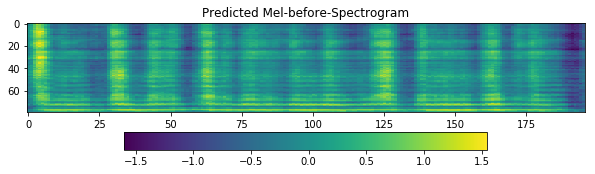

In [18]:
mel_outputs_ = np.reshape(o[0][0], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

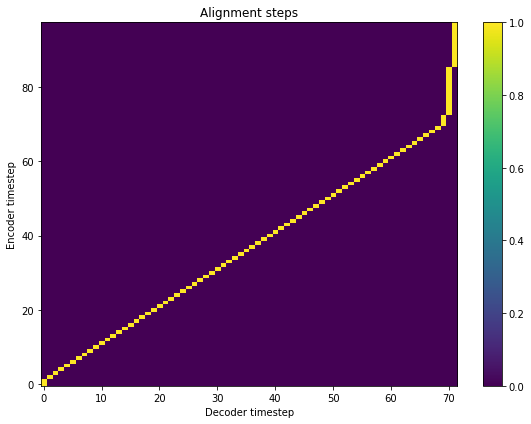

In [19]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    o[-1][0],
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

In [20]:
saver = tf.train.Saver()
saver.save(sess, 'test/model.ckpt')

'test/model.ckpt'

In [21]:
!ls -lh test

total 714544
-rw-r--r--  1 huseinzolkepli  staff    77B Oct  9 23:40 checkpoint
-rw-r--r--  1 huseinzolkepli  staff   304M Oct  9 23:40 model.ckpt.data-00000-of-00001
-rw-r--r--  1 huseinzolkepli  staff    83K Oct  9 23:40 model.ckpt.index
-rw-r--r--  1 huseinzolkepli  staff    30M Oct  9 23:40 model.ckpt.meta
